In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.append("..") 
from src import load_realized_vol, build_har_features,load_earnings,load_implied_vol  # etc.
from src.load_data import load_close_to_close_realized_volatility
from src.features import fit_har_regression
from src.signals import compute_signal_matrix
from src.forecast import create_forecast
from src.signals import size_positions
from src.analytic_utils import filter_earnings,create_earnings_mask,filter_earnings_by_ticker, align_multiple


import pandas as pd
import pandas_market_calendars as mcal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np


In [3]:
config = {
    "har_windows": {"short": 1, "medium": 5, "long": 21},
    "forecast_horizon": 5,
    "ranking_threshold": 0.9,
    "train_test_split_ratio": 0.7,
    "train_test_gap_days": 21,
}

Loading and processing data...

In [4]:
realized = load_realized_vol()
earnings = load_earnings()
min_date,max_date = realized.index.min(), realized.index.max()
earnings_subset = filter_earnings(earnings, min_date, max_date)
earnings_subset = filter_earnings_by_ticker(earnings_subset, realized.columns)
earnings_mask = create_earnings_mask(realized, earnings_subset)
close_realized_vol, close_future_realized_vol = load_close_to_close_realized_volatility("../data/all_vols.csv", realized_vol_term=config["forecast_horizon"])



implied = load_implied_vol("../output/features_data.csv", earnings_subset)


/Users/stirlitz/ncGitHub/vol_forecast_project/vol_forecast/notebooks/../src/load_data.py:121: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns = df_prices.pct_change()


In [5]:
har_1d, har_1w, har_1m = build_har_features(realized,term_1d=config["har_windows"]["short"], term_1w=config["har_windows"]["medium"], term_1m=config["har_windows"]["long"])
har_factors = fit_har_regression(realized, har_1d.shift(1), har_1w.shift(1), har_1m.shift(1), earnings_mask=earnings_mask)
forecast = create_forecast(har_1d, har_1w, har_1m, har_factors)

realized_adjusted = realized.copy()
realized_adjusted[earnings_mask] = forecast[earnings_mask]
har_1d, har_1w, har_1m = build_har_features(realized_adjusted, term_1d=config["har_windows"]["short"], term_1w=config["har_windows"]["medium"], term_1m=config["har_windows"]["long"])
forecast = create_forecast(har_1d, har_1w, har_1m, har_factors)
signal_matrix = compute_signal_matrix(forecast, implied) #both forecast and implied are as of today
positions = size_positions(signal_matrix, implied.loc[forecast.index], method='unit', threshold=0.0)


In [9]:
aligned_realized, aligned_implied,aligned_forecast, aligned_signal,aligned_positions= align_multiple(close_future_realized_vol, implied, forecast, signal_matrix, positions, align_columns=True)

In [28]:
def split_train_test_multiple(*dfs, split_ratio=0.7, train_test_gap_days=21):
    # Explicitly extract sorted unique dates from the first DataFrame
    unique_dates = dfs[0].index.get_level_values(0).unique().sort_values()

    # Compute explicit split points
    split_point = int(len(unique_dates) * split_ratio)
    train_dates = unique_dates[:split_point]
    test_dates = unique_dates[split_point + train_test_gap_days:]

    train_dfs = []
    test_dfs = []

    for df in dfs:
        train_df = df[df.index.get_level_values(0).isin(train_dates)]
        test_df = df[df.index.get_level_values(0).isin(test_dates)]
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    return train_dfs, test_dfs

In [29]:
train_dfs, test_dfs = split_train_test_multiple(
    aligned_realized,
    aligned_implied,
    aligned_forecast,
    aligned_signal,
    aligned_positions,
    split_ratio=config["train_test_split_ratio"],
    train_test_gap_days=config["train_test_gap_days"]
)

(train_aligned_realized,
 train_aligned_implied,
 train_aligned_forecast,
 train_aligned_signal,
 train_aligned_positions) = train_dfs

(test_aligned_realized,
 test_aligned_implied,
 test_aligned_forecast,
 test_aligned_signal,
 test_aligned_positions) = test_dfs

In [38]:
def create_regressor_inputs(signal, implied, realized):
    X = signal.stack().rename("signal")
    #y = (aligned_realized.loc[forecast.index]>aligned_implied.loc[forecast.index]).stack().astype(int).reset_index(drop=True)
    #y = (realized > implied).stack().astype(int)
    y = (realized - implied).stack()
    # Intersection of multi-indices
    common_idx = X.index.intersection(y.index)

    X_aligned = X.loc[common_idx]
    y_aligned = y.loc[common_idx]

    # Ready for modeling
    X_df = X_aligned.reset_index(drop=True).to_frame()
    y_series = y_aligned.reset_index(drop=True)
    return X_df, y_series

X_df, y_series = create_regressor_inputs(train_aligned_signal, train_aligned_implied, train_aligned_realized)

clf= RandomForestRegressor(max_depth=3).fit(X_df, y_series)
y_pred = clf.predict(X_df)
mse = mean_squared_error(y_series, y_pred)
mae = mean_absolute_error(y_series, y_pred)
r2 = r2_score(y_series, y_pred)


X_test_df, y_test_series = create_regressor_inputs(test_aligned_signal, test_aligned_implied, test_aligned_realized)
y_test_pred = clf.predict(X_test_df)
test_mse = mean_squared_error(y_test_series, y_test_pred)
test_mae = mean_absolute_error(y_test_series, y_test_pred)
test_r2 = r2_score(y_test_series, y_test_pred)
# Clearly print metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

print(f"Test Mean Squared Error: {test_mse:.4f}")
print(f"Test Mean Absolute Error: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

Mean Squared Error: 0.0309
Mean Absolute Error: 0.0969
R² Score: 0.0242
Test Mean Squared Error: 0.0145
Test Mean Absolute Error: 0.0768
Test R² Score: 0.0337


/var/folders/c1/dv7w7b2x49j3spqsxnz6y_sw0000gn/T/ipykernel_86082/1297457086.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


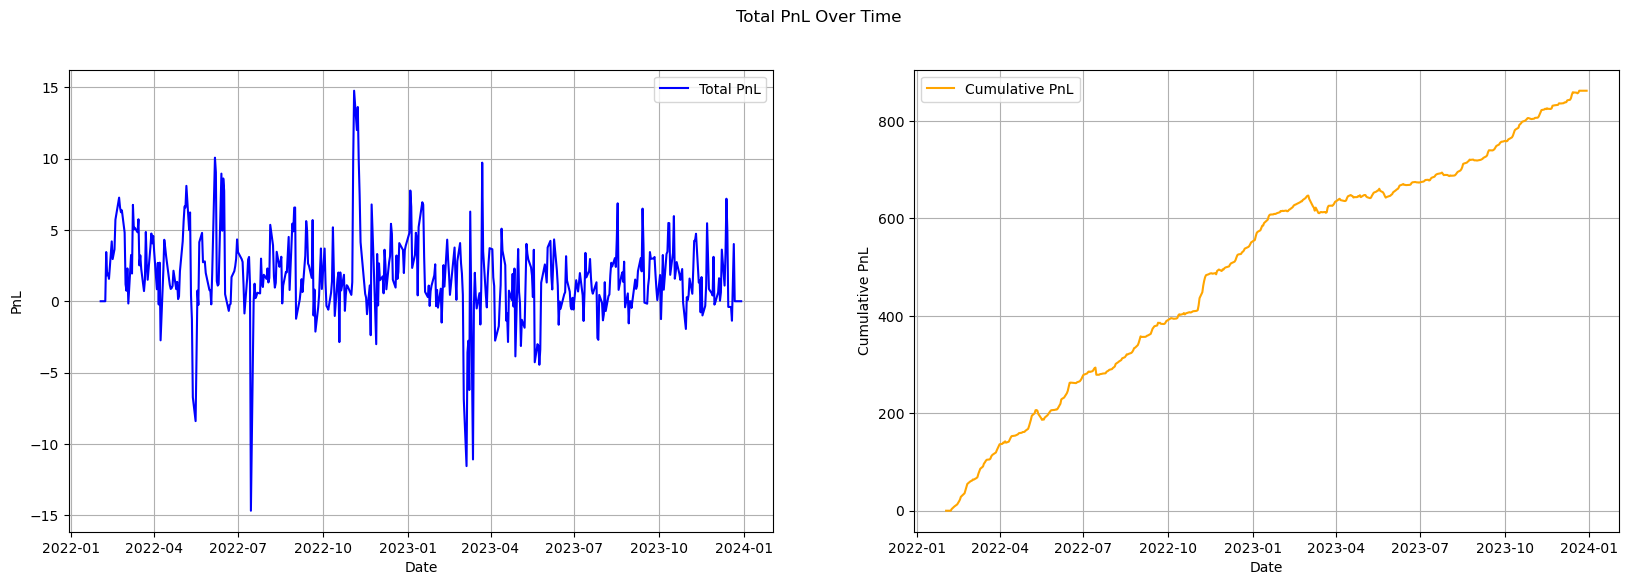

In [66]:
import matplotlib.pyplot as plt
rank_threshold = 0.9
signal_rank = aligned_signal.rank(axis=1, pct=True)
top = (signal_rank>=rank_threshold)
bottom = signal_rank<=1-rank_threshold
buy_pnl= aligned_realized[top==True]- aligned_implied[top==True]
bottom_pnl = aligned_realized[bottom] - aligned_implied[bottom]

total_pnl = buy_pnl.sum(axis=1) - bottom_pnl.sum(axis=1)
total_pnl=total_pnl/rank_threshold
cumulative_pnl = total_pnl.cumsum()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.plot(total_pnl.index, total_pnl, label='Total PnL', color='blue')
ax2.plot(cumulative_pnl.index, cumulative_pnl, label='Cumulative PnL', color='orange')
fig.suptitle('Total PnL Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('PnL')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative PnL')

ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()
fig.show()

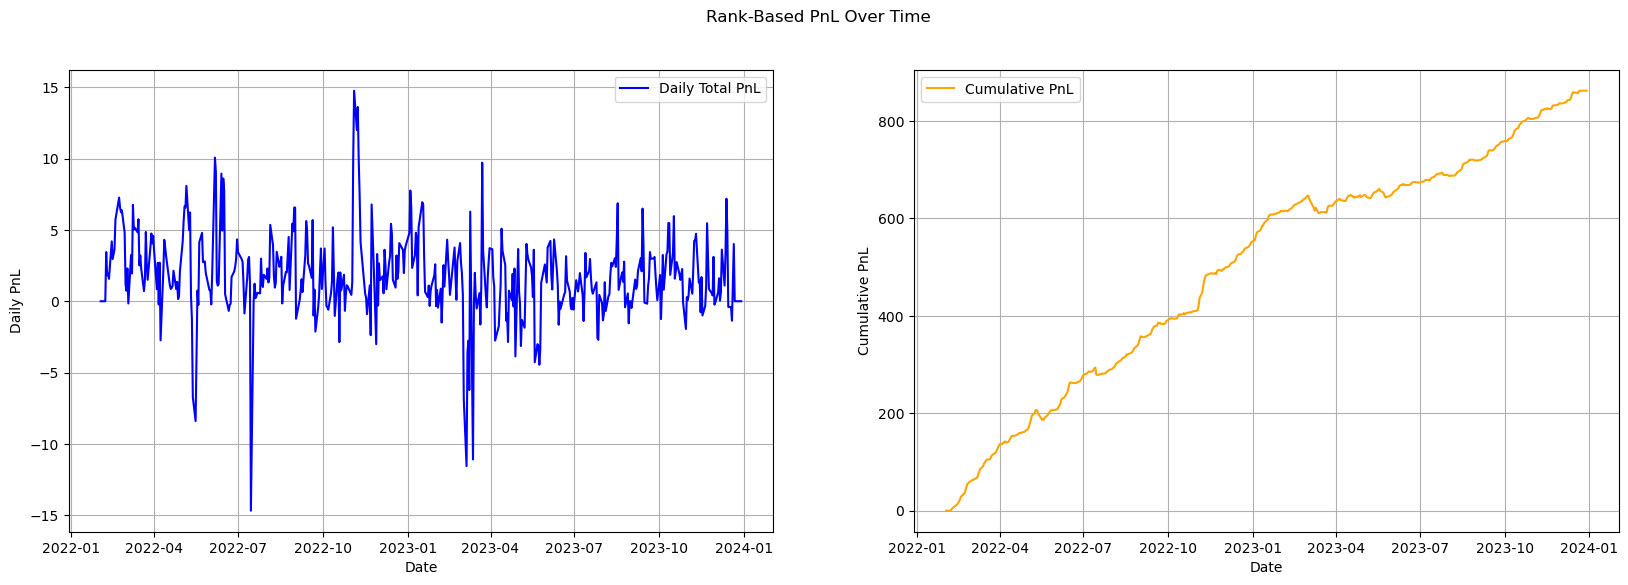

In [67]:
import matplotlib.pyplot as plt

def compute_rank_based_pnl(signal, realized, implied, rank_threshold=0.9):
    signal_rank = signal.rank(axis=1, pct=True)

    # Explicitly define long and short positions
    top = signal_rank >= rank_threshold
    bottom = signal_rank <= (1 - rank_threshold)

    # Calculate long and short PnL explicitly
    buy_pnl = (realized - implied).where(top)
    sell_pnl = (implied - realized).where(bottom)

    # Sum positions explicitly (ignoring NaNs)
    daily_pnl = (buy_pnl.sum(axis=1) + sell_pnl.sum(axis=1)) / rank_threshold
    cumulative_pnl = daily_pnl.cumsum()

    return daily_pnl, cumulative_pnl

# Usage explicitly:
daily_pnl, cumulative_pnl = compute_rank_based_pnl(aligned_signal, aligned_realized, aligned_implied, rank_threshold=0.9)

# Explicit plotting for clarity:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(daily_pnl.index, daily_pnl, label='Daily Total PnL', color='blue')
ax2.plot(cumulative_pnl.index, cumulative_pnl, label='Cumulative PnL', color='orange')

fig.suptitle('Rank-Based PnL Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily PnL')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative PnL')

ax1.legend()
ax1.grid(True)
ax2.legend()
ax2.grid(True)

plt.show()

In [71]:
holding_periods = np.arange(1, 40)
pnl_results = []

for period in holding_periods:
    # Load volatility explicitly with changing holding period
    realized_vol, future_realized_vol = load_realized_volatility("../data/all_vols.csv", realized_vol_term=period)
    
    # Explicitly align datasets
    aligned_realized, aligned_implied, aligned_forecast, aligned_signal = align_multiple(
        realized_vol, implied, forecast, signal_matrix, align_columns=True
    )
    
    # Explicitly recompute PnL
    daily_pnl, cumulative_pnl = compute_rank_based_pnl(
        aligned_signal, future_realized_vol, aligned_implied, rank_threshold=0.9
    )
    
    # Store clearly aligned final cumulative pnl
    pnl_results.append(cumulative_pnl.iloc[-1])

/Users/stirlitz/ncGitHub/vol_forecast_project/vol_forecast/notebooks/../src/load_data.py:121: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns = df_prices.pct_change()
/Users/stirlitz/ncGitHub/vol_forecast_project/vol_forecast/notebooks/../src/load_data.py:121: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns = df_prices.pct_change()
/Users/stirlitz/ncGitHub/vol_forecast_project/vol_forecast/notebooks/../src/load_data.py:121: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-lea

In [72]:
pnl_results

[np.float64(937.2429216300491),
 np.float64(956.5960360094184),
 np.float64(944.2781172590418),
 np.float64(922.8945487774279),
 np.float64(862.2055077069984),
 np.float64(785.9944415867175),
 np.float64(742.3301658147344),
 np.float64(737.8328347864561),
 np.float64(761.6990571212538),
 np.float64(775.2778285533543),
 np.float64(780.9823003772416),
 np.float64(789.7725046423404),
 np.float64(795.3918273050623),
 np.float64(808.8136405518263),
 np.float64(813.4102173540775),
 np.float64(822.6691308147057),
 np.float64(836.4965260205337),
 np.float64(853.6950417662064),
 np.float64(875.8597219335354),
 np.float64(890.5705587178037),
 np.float64(907.4337562501734),
 np.float64(924.9252700554351),
 np.float64(938.7152067059388),
 np.float64(949.4538967072926),
 np.float64(961.6779120014616),
 np.float64(973.813280047099),
 np.float64(982.756325423084),
 np.float64(989.4254518189464),
 np.float64(996.9825962907237),
 np.float64(1004.6564477912984),
 np.float64(1010.9993288874559),
 np.floa

In [73]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Prepare data explicitly
X_hp = holding_periods.reshape(-1, 1)
y_pnl = np.array(pnl_results)

# Mean function (simple mean explicitly)
y_mean = np.mean(y_pnl)

# Fit GP explicitly to residuals (deviation from mean)
kernel = C(1.0, constant_value_bounds="fixed") * RBF(length_scale=5.0, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, optimizer=None, normalize_y=True)
gp.fit(X_hp, y_pnl - y_mean)

GaussianProcessRegressor(alpha=0.0001, kernel=1**2 * RBF(length_scale=5),
                         normalize_y=True, optimizer=None)